## Helio Inaba - CQF June 2023 Final Project 
## Optimal Hedging with Advanced Delta Modelling

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import scipy
from scipy.stats import norm
from scipy.optimize import minimize

from IPython.display import Latex
from datetime import datetime
import os

#pd.set_option('display.max_columns', None)
pd.reset_option('^display.', silent=True)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.9)


#### Defining Functions

In [2]:
def gaussian(data, bins):

    #Returns a normal distribution with the same mean, variance and number of divisions of a given dataset.
    
    return 1/(data.std()*np.sqrt(2*np.pi))*(np.exp(-(bins - data.mean())**2/(2*data.std()**2)))


def black_scholes(S, K, sigma, T, r, option_type='call'):

    #Returns the Black-Scholes Price of an option.

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d1 = norm.cdf(d1)
    n_d2 = norm.cdf(d2)

    if option_type == 'call':
        V = n_d1*S-n_d2*K*np.exp(-r*T)
    elif option_type == 'put':
        V = (1-n_d2)*K*np.exp(-r*T) - S*(1-n_d1)
    else:
        raise ValueError('Option Type not supported')
    return V


def bs_delta(S, K, sigma, T, r):

    #Returns the Black-Scholes Delta of an option.

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    n_d1 = norm.cdf(d1)
    
    return n_d1


def bs_gamma(S, K, sigma, T, r):

    #Returns the Black-Scholes Gamma of an option

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def bs_vega(S, K, sigma, T, r):

    #Returns the Black-Scholes Vega of an option.

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    
    return S*norm.pdf(d1)*np.sqrt(T)


def bs_theta(S, K, sigma, T, r):

    #Returns the Black-Scholes Theta of an option.

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    theta = -S*norm.pdf(d1)*sigma/(2*np.sqrt(T))
    theta -= r*K*np.exp(-r*T)*n_d2

    return theta

def bs_rho(S, K, sigma, T, r):

    #Returns the Black-Scholes Rho of an option.

    d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
    d2 = d1-sigma*np.sqrt(T)
    n_d2 = norm.cdf(d2)

    return K*T*np.exp(-r*T)*n_d2


def euler_maruyama(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    #returns n_simulations prices paths with n_periods time intervals each using the Euler-Maruyama discretization method.

    prices = np.zeros((n_periods, n_simulations))
    prices[0] = s0

    for i in range(1, n_periods):

        prices[i] = prices[i-1]*(1 + return_rate*expiry_T/n_periods + sigma*np.sqrt(expiry_T/n_periods)*np.random.normal(loc=0.0, scale=1.0, size=n_simulations))

    prices = pd.DataFrame(prices)
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def milstein(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    #returns n_simulations prices paths with n_periods time intervals each using the Milstein discretization method.
    
    prices = np.zeros((n_simulations, n_periods+1))
    prices[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    prices[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)

    prices = pd.DataFrame(np.transpose(prices))
    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices

def antithetic_variables(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    #returns n_simulations prices paths with n_periods time intervals each using the Milstein discretization method.
    #The Milstein scheme is run for n_simulations/2 paths and its stochastic portion is replicated with opposite side for the other half of simulations.
    
    
    prices_plus = np.zeros((n_simulations, n_periods+1))
    prices_plus[:,0] = s0

    prices_minus = np.zeros((n_simulations, n_periods+1))
    prices_minus[:,0] = s0

    A_matrix = np.sqrt(expiry_T/n_periods)*np.tri(n_periods,n_periods)
    z = np.random.normal(loc=0.0, scale=1.0, size=(n_periods,n_simulations))
    z_minus = -z

    wiener_matrix = np.matmul(A_matrix, z)
    wiener_matrix = np.transpose(wiener_matrix)

    wiener_matrix_minus = np.matmul(A_matrix, z_minus)
    wiener_matrix_minus = np.transpose(wiener_matrix_minus)

    prices_plus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix)
    prices_minus[:,1:] = s0*np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods)+sigma*wiener_matrix_minus)

    prices_plus = pd.DataFrame(np.transpose(prices_plus))
    prices_minus = pd.DataFrame(np.transpose(prices_minus))
    
    prices_plus.index.name = 'period'
    prices_plus.index.columns = 'simulation'

    prices_minus.index.name = 'period'
    prices_minus.index.columns = 'simulation'

    return prices_plus, prices_minus


def fill_bridge_array(a, b, delta_t, z=None):

    #Returns a Brownian Bridge connecting point a to point b.
    #It can either receive or generate a random variable that fills the gap.
    
    if type(z) == type(None):
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z

def sobol_prices(s0, expiry_T, sigma, return_rate, n_periods, n_simulations):

    #returns n_simulations prices paths with n_periods time intervals using Sobol variables.
    #For each path simulation, it firsts uses the first number of its sequence to generate the final random point, then fills the path using the fill_bridge_array.


    n = int(np.log2(n_periods))

    compounding_array = np.exp((return_rate-(sigma**2)/2)*np.linspace(start=expiry_T/n_periods,stop=expiry_T,num=n_periods))

    W_t = np.empty((n_periods+1, n_simulations))
    W_t[:] = np.nan
    W_t[0] = 0.0

    prices = np.zeros((n_periods+1, n_simulations))
    prices = pd.DataFrame(prices, index=np.arange(0, 1+1/(2**n), 1/(2**n)))
    prices.iloc[0] = s0

    sampler = scipy.stats.qmc.Sobol(d=n_periods, scramble=True)
    sample = sampler.random_base2(int(np.log2(n_simulations)))
    sample = np.transpose(sample)
    norm_sample = norm.ppf(sample)

    k = 0
    W_t[-1,:] = norm_sample[k,:]

    df_wt = pd.DataFrame(W_t, index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):
            k+=1
            df_wt.loc[j] = fill_bridge_array(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1), z=norm_sample[k,:])
            
    prices.iloc[1:] = s0*(np.exp(sigma*df_wt.iloc[1:,].values).T*compounding_array).T
    prices.index = prices.index*expiry_T

    prices.index.name = 'period'
    prices.index.columns = 'simulation'

    return prices


def fill_bridge(a, b, delta_t, z=None):

    
    if z == None:
        return (a+b)/2 + np.sqrt((delta_t/4))*np.random.normal(loc=0.0, scale=1.0, size=1)[0]
    else:
        return (a+b)/2 + np.sqrt((delta_t/4))*z
    

def brownian_bridge(w0, w1, n):


    df_wt = pd.DataFrame(columns=['W_t'], index=np.arange(0, 1+1/(2**n), 1/(2**n)))

    df_wt.iloc[0] = w0
    df_wt.iloc[-1] = w1

    for i in range(1, n+1):
        
        for j in ((1/2)**i)*np.arange(1, 2**(i)+1, 2):

            df_wt.loc[j] = fill_bridge(a=df_wt.loc[j-(1/2)**i], b=df_wt.loc[j+(1/2)**i], delta_t=(1/2)**(i-1))

    return df_wt


def call_price(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    #Returns the call price and the PV of the payoff of each simulation, using the Euler-Maruyama scheme.

    prices_path = euler_maruyama(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_milstein(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    #Returns the call price and the PV of the payoff of each simulation, using the Milstein scheme.

    prices_path =  milstein(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_anti(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    #Returns the call price and the PV of the payoff of each simulation, using Antithetics variables.

    prices_plus, prices_minus = antithetic_variables(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = .5*(np.maximum(prices_plus.iloc[-1]-strike_E,0)+np.maximum(prices_minus.iloc[-1]-strike_E,0))
    
    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            pd.Series(payoff*np.exp(-risk_free*(expiry_T)))]


def call_price_sobol(s0, strike_E, expiry_T, sigma, risk_free, n_periods, n_simulations):

    #Returns the call price and the PV of the payoff of each simulation, using prices paths generated by Sobol sequences.

    prices_path = sobol_prices(s0, expiry_T, sigma, risk_free, n_periods, n_simulations)
    payoff = np.maximum(prices_path.iloc[-1]-strike_E,0)

    return [np.exp(-risk_free*(expiry_T))*np.mean(payoff),
            payoff*np.exp(-risk_free*(expiry_T))]

### Part I: Volatility Arb with improved GBM and Monte-Carlo ###

1. Consider improvements to GBM asset evolution (Euler-Maruyana/Milstein schemes). <br> Optionally, can consider modelling asset with jumps, eg, Merton jump diffusion, without going into stochastic volatility, eg Heston-Nandi. <br> Variance Gamma is also relevant but suited for single-name assets with extreme movements.
 - consider MC variance reduction techniques, such as antithetic variates; <br>
 - best practice is low discrepancy sequences, eg Sobol with the Brownian bridge.


<IPython.core.display.Latex object>

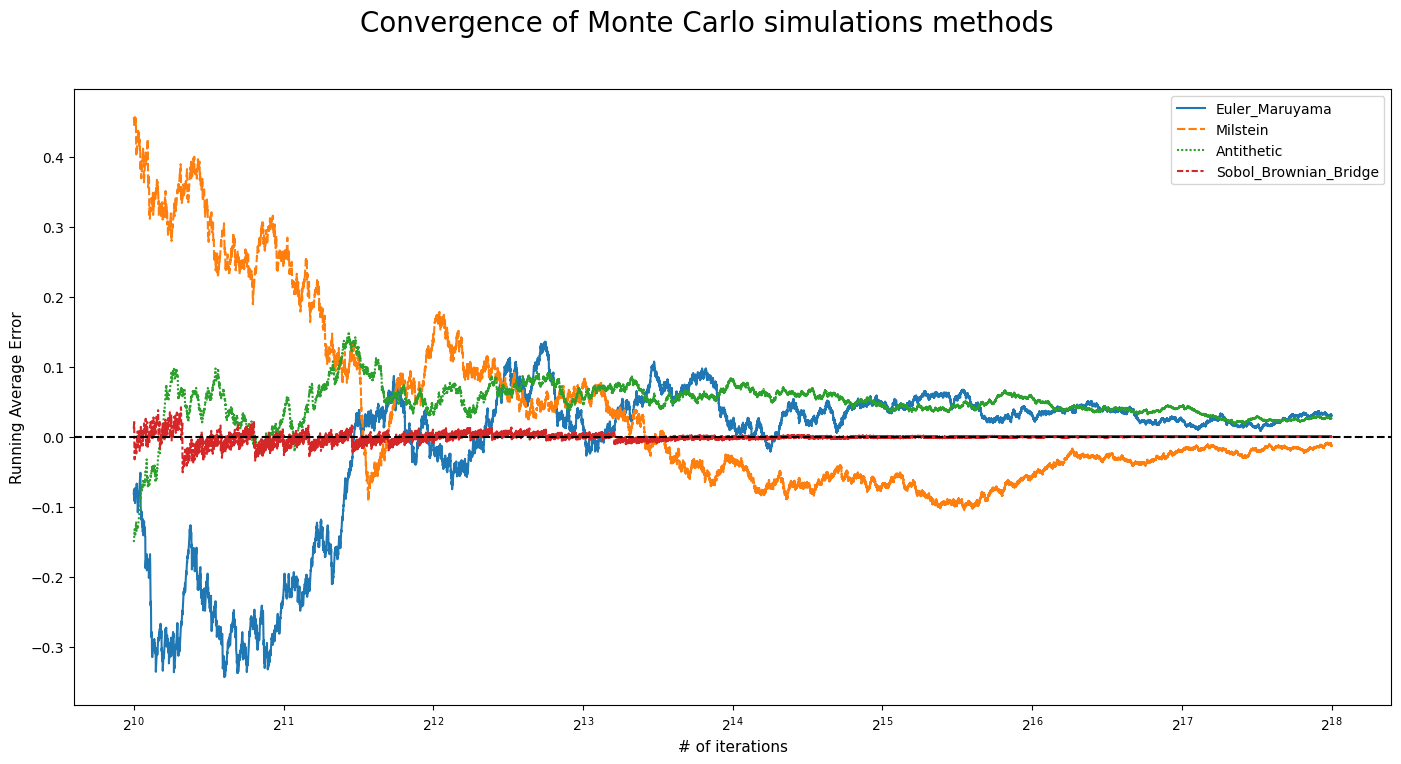

<IPython.core.display.Latex object>

In [3]:
# Defining Constants
S = 50
K = 55
sigma = .30
r = .1
T = 360/360

# Calculate BS price
bs_price = black_scholes(S, K, sigma, T, r)

df_mc_errors = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_Brownian_Bridge'])
df_mc_variances = pd.DataFrame(columns=['Euler_Maruyama', 'Milstein', 'Antithetic', 'Sobol_Brownian_Bridge'])

n_simulations = 2**18
n_periods = 2**9

dict_params = {'s0': S,
               'strike_E': K,
               'expiry_T': T, 
               'sigma': sigma, 
               'risk_free': r, 
               'n_periods': n_periods, 
               'n_simulations': int(n_simulations)}


# Calculate BS price
euler_maruyama_option_prices = pd.Series(call_price(**dict_params)[1])
milstein_option_prices = pd.Series(call_price_milstein(**dict_params)[1])
antithetic_option_prices = pd.Series(call_price_anti(**dict_params)[1])
sobol_option_prices = call_price_sobol(**dict_params)[1]

df_mc_errors['Euler_Maruyama'] = bs_price - euler_maruyama_option_prices.expanding().mean()
df_mc_errors['Milstein'] = bs_price - milstein_option_prices.expanding().mean()
df_mc_errors['Antithetic'] = bs_price - antithetic_option_prices.expanding().mean()
df_mc_errors['Sobol_Brownian_Bridge'] = bs_price - sobol_option_prices.expanding().mean()

str_latex = r"""\begin{aligned}
& \text European\ Call\ Parameters\\
&\begin{array}{|l|r|r|r|r|r|r|}
\hline \hline \text { Parameter } & \text Stock\ Price & \text Strike\ Price & \text Implied\ Volatility & \text Risk\ Free & Expiry\ (Years) & Black\ -Scholes\ Price \\
\hline 

Value & 
""" + f'{S:.2f}' + r"""
& """ + f'{K:.2f}' + r"""
& """ + f'{sigma*100}' + r'\%' + r"""
& """ + f'{r*100}' + r'\%' + r"""
& """ + f'{T}' + r"""
& """ + f'{bs_price:.2f}' + r"""

\\
\hline
\end{array}
\end{aligned}
"""
display(Latex(str_latex))

fig, ax = plt.subplots(figsize=(17, 8))

fig.suptitle('Convergence of Monte Carlo simulations methods ', fontsize=20)

plt.ylabel('Running Average Error', fontsize=11)
plt.xlabel('# of iterations', fontsize=11)

sns.lineplot(df_mc_errors.loc[1024:], 
             ax=ax)

plt.axhline(y=0.0, color='black', linestyle='--')

ax.set_xscale('log', base=2)

plt.show()

str_latex = r"""\begin{aligned}
& \text {Error ($10^{-3}$) after $n$ iterations}\\
&\begin{array}{|l|r|r|r|}
\hline \hline \text { Method } & \text {$n = 2^{12}$} & \text {$n = 2^{15}$} & \text {$n = 2^{18}$} \\
\hline 

Euler \ Maruyama & 
""" + f'{np.round(df_mc_errors.loc[2**12-1].Euler_Maruyama*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**15-1].Euler_Maruyama*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**18-1].Euler_Maruyama*1e3, 2):,}' + r"""

\\Milstein & 
""" + f'{np.round(df_mc_errors.loc[2**12-1].Milstein*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**15-1].Milstein*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**18-1].Milstein*1e3, 2):,}' + r"""

\\Antithetic & 
""" + f'{np.round(df_mc_errors.loc[2**12-1].Antithetic*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**15-1].Antithetic*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**18-1].Antithetic*1e3, 2):,}' + r"""

\\Sobol \ (Brownian \ Bridge) & 
""" + f'{np.round(df_mc_errors.loc[2**12-1].Sobol_Brownian_Bridge*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**15-1].Sobol_Brownian_Bridge*1e3, 2):,}' + r"""
& """ + f'{np.round(df_mc_errors.loc[2**18-1].Sobol_Brownian_Bridge*1e3, 2):,}' + r"""

\\
\hline
\end{array}
\end{aligned}
"""

Latex(str_latex)



The use of Sobol sequences with Brownian Bridge greatly improves the convergence of Monte Carlo calculation by orders of magnitude . <br>
This is caused by its low-discrepancy properties that generates random numbers more evenly distributed; <br>
<br>
The use of antithetic variables decreses the variance of results without the necessity of further generation of random numbers <br>
This is because it ensures symmetry on returns distrbution, forcing the distribution towards the central value.


2. Under the condition of known future realised volatility $ V_{a} > V_{i} $ , analytically and with Monte-Carlo confirm the items below. <br> Report with both, complete mathematical workings to fold $ P\&L_{t} $ and simulations of $ P\&L_{t} $.
 - confirm actual volatility hedging leads to the known total $ P\&L $;
 - confirm and demonstrate implied volatility hedging leads to uncertain total, path-dependent $ P\&L $, and characterise on which parameters/Greeks it depends.

### Hedging with Actual Volatility
By buying a call option with understaded implied volatility and replicating the call with actual volatility on the opposite side trought a delta hedged portfolio, \
the excess return converges to the difference of option values measured with the implied volatility and measured with actual volatility.

This can be shown by marking both positions to market and following its evolutions

$$
\begin{aligned}
& \text {Total position at time $ t $ and $ t+dt $}\\
&\begin{array}{|c|c|c|c|}
\hline \hline \text { Instrument } & \text { Value at t} & \text { Value at t + dt } & \text { Profit from t to t+dt } \\
\hline Call & V_{i} & V_{i}+dV_{i} & dV_{i} \\
Stock \ (short) & -\Delta_{a}S & -\Delta_{a}(S + dS) & -\Delta_{a}dS\\
Cash & (-V_{i} + \Delta_{a}S) & (-V_{i} + \Delta_{a}S)(1+r \ dt)& r(-V_{i} + \Delta_{a}S)dt\\
\hline
Total & 0 & dV_{i} - \Delta_{a}dS - r(V_{i} - \Delta_{a}S)dt & dV_{i} - \Delta_{a}dS - r(V_{i} - \Delta_{a}S)dt \\
\hline
\end{array}
\end{aligned}
$$

Beacuse the option would be correctly value at $V_{a}$ then we have


$$  dV_{a} - \Delta_{a}dS  - r(V_{a} - \Delta_{a}S) dt = 0$$

Subtracing the previous expression from the profit we have

$$  dV_{i} - dV_{a} + r(V_{a} - \Delta_{a}S) - r(V_{i} - \Delta_{a}S) dt $$

All $dS$ terms vanish beacuse the portfolio is delta hedged

$$ = dV_{i} - dV_{a} + r(V_{a} - V_{i})dt $$

using the Integrating Factor $e^{-rt}$
$$ = e^{rt} d(e^{-rt}(V_{i}-V_{a})) $$ 

PV-ing that increment of profit to $t_{0}$ gives

$$ = e^{-r(t-t_{0})}e^{rt} d(e^{-rt}(V_{i}-V_{a})) = e^{rt_{0}}d(e^{-rt}(V_{i}-V_{a}))$$ 

Integrating all the increments at PV:

$$ e^{rt_{0}}\int_{t_{0}}^{T}d(e^{-rt}(V_{i}-V_{a})) = V_{a}-V_{i} $$

Expected Total Profit at FV:

$$ e^{rT}(V_{a}-V_{i}) $$

Now, we implement this in the following code:

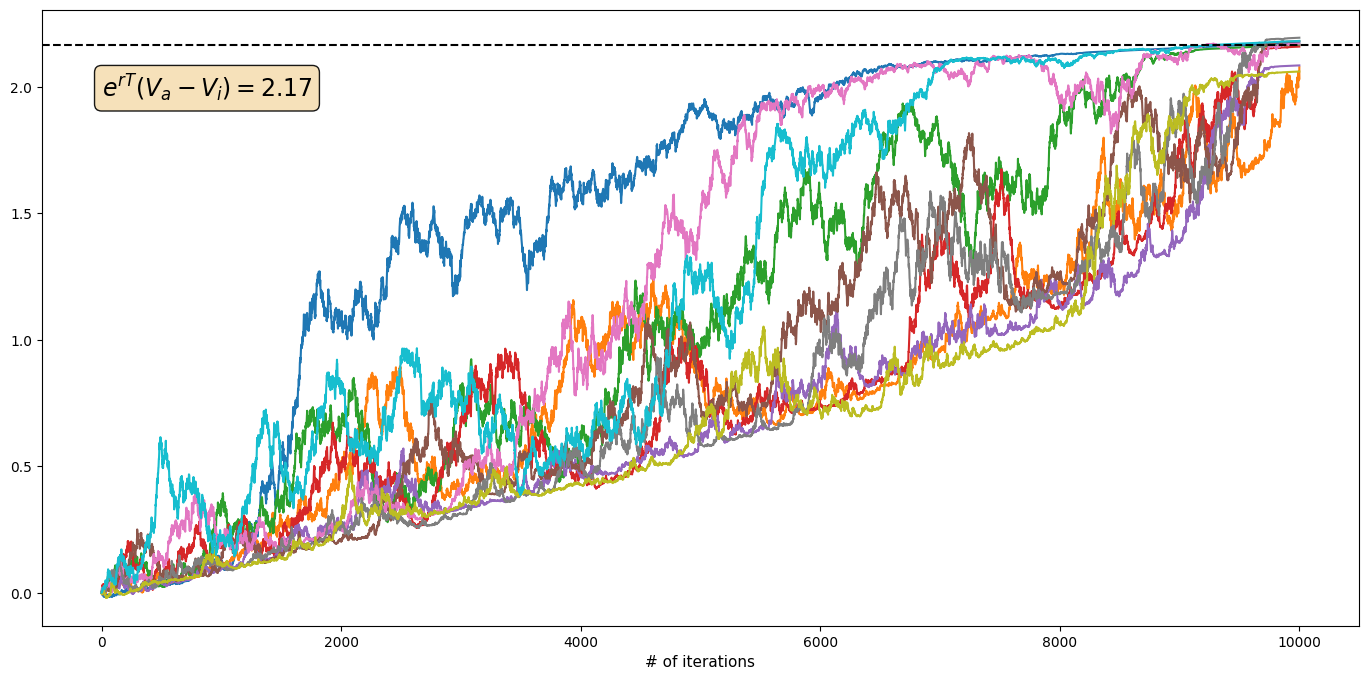

In [4]:
def delta_hedged_ptf(stock_path, K, T, sigma, r):

    # Given an asset price evolution, Strike, maturity, volatility and risk-free rate, 
    # this functions returns the evolution of the position of a delta hedged portfolio 

    df_hedged_ptf = pd.DataFrame(columns=['Cash_Position', 'Cash_Rebalance', 
                                          'Daily_Interest', '#_Stocks', 
                                          'Ptf_Stock', 'Ptf_Total'],
                                 index=range(0,len(stock_path)))
    
    
    s0 = stock_path[0]
    n_periods = len(stock_path)
    
    df_hedged_ptf['Cash_Position'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Cash_Rebalance'] = [0.0]*len(df_hedged_ptf)
    df_hedged_ptf['Daily_Interest'] = [0.0]*len(df_hedged_ptf)

    df_hedged_ptf['#_Stocks'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_hedged_ptf.index, stock_path)]
    df_hedged_ptf.loc[0, 'Cash_Position'] = -df_hedged_ptf.loc[0, '#_Stocks']*s0

    df_hedged_ptf['Ptf_Stock'] = df_hedged_ptf['#_Stocks']*stock_path
    df_hedged_ptf['Cash_Rebalance'] = -df_hedged_ptf['#_Stocks'].diff().fillna(0)*stock_path

    for i in df_hedged_ptf.index[1:]:

        df_hedged_ptf.loc[i, 'Daily_Interest'] = df_hedged_ptf.loc[i-1, 'Cash_Position']*r*T/n_periods
        df_hedged_ptf.loc[i, 'Cash_Position'] = df_hedged_ptf.loc[i-1, 'Cash_Position'] + df_hedged_ptf.loc[i, 'Cash_Rebalance'] + df_hedged_ptf.loc[i, 'Daily_Interest']

    df_hedged_ptf['Ptf_Total'] = df_hedged_ptf['Cash_Position'] + df_hedged_ptf['Ptf_Stock']

    return df_hedged_ptf


def call_ptf(stock_path, K, T,sigma, r):

    # Given an asset price evolution, Strike, maturity, volatility and risk-free rate, 
    # this functions returns the evolution of the position of a portfolio with a single call.

    s0 = stock_path[0]
    n_periods = len(stock_path)

    V_i = black_scholes(S=s0, K=K, sigma=sigma, T=T, r=r)

    df_call_ptf = pd.DataFrame(columns=['Call_Price', 'Call_Carry', 'Call_PnL'],
                               index=range(0,len(stock_path)))

    df_call_ptf['Call_Price'] = [black_scholes(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Carry'] = [V_i*(1-np.exp(r*T*t/n_periods)) for t in df_call_ptf.index]
    df_call_ptf['Call_PnL'] = df_call_ptf['Call_Price'] - df_call_ptf.loc[0,'Call_Price'] + df_call_ptf['Call_Carry']
    
    df_call_ptf['Call_Delta'] = [bs_delta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Gamma'] = [bs_gamma(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Theta'] = [bs_theta(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Rho'] = [bs_rho(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]
    df_call_ptf['Call_Vega'] = [bs_vega(S=s, K=K, sigma=sigma, T=T*(1-t/n_periods), r=r) for t,s in zip(df_call_ptf.index, stock_path)]

    df_call_ptf['PnL_Delta'] = (df_call_ptf['Call_Delta'].shift(1)*stock_path.diff()).cumsum()
    df_call_ptf['PnL_Gamma'] = (df_call_ptf['Call_Gamma'].shift(1)*np.square(stock_path.diff())).cumsum()/2
    df_call_ptf['PnL_Theta'] = (df_call_ptf['Call_Theta'].shift(1)*T/n_periods).cumsum()
    df_call_ptf['PnL_Carry'] = df_call_ptf['Call_Carry']

    df_call_ptf['PnL_Greeks'] = df_call_ptf[['PnL_Delta','PnL_Gamma','PnL_Theta','PnL_Carry']].sum(axis=1)

    return df_call_ptf

    
S = 50
K = 55
sigma_i = .30
sigma_a = .40

r = .1
T = 1.0 #in years

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

n_periods = 10000

df_price_paths = euler_maruyama(s0=S, expiry_T=T, sigma=sigma_a, return_rate=r, n_periods=n_periods, n_simulations=10)

fig, ax = plt.subplots(figsize=(17, 8))

for i in df_price_paths.columns:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_a, r=r).Ptf_Total

    sns.lineplot(y=(df_call - df_ptf).values,
                 x=(df_call - df_ptf).index,
                 ax=ax)

plt.axhline(y=np.exp(r*T)*(V_a-V_i), color='black', linestyle='--')
plt.xlabel('# of iterations', fontsize=11)

ax.text(x = 0, 
        y = V_a - V_i, 
        s = r'$ e^{rT}(V_{a}-V_{i}) = $' + str(np.round(np.exp(r*T)*(V_a-V_i),2)), 
        bbox=props,
        fontsize=17)

plt.show()


The simulations shows that, as expected, the $P\&L$ converges to the Future Value of $V_{a}-V_{i}$

#### Hedging with Implied Volatility

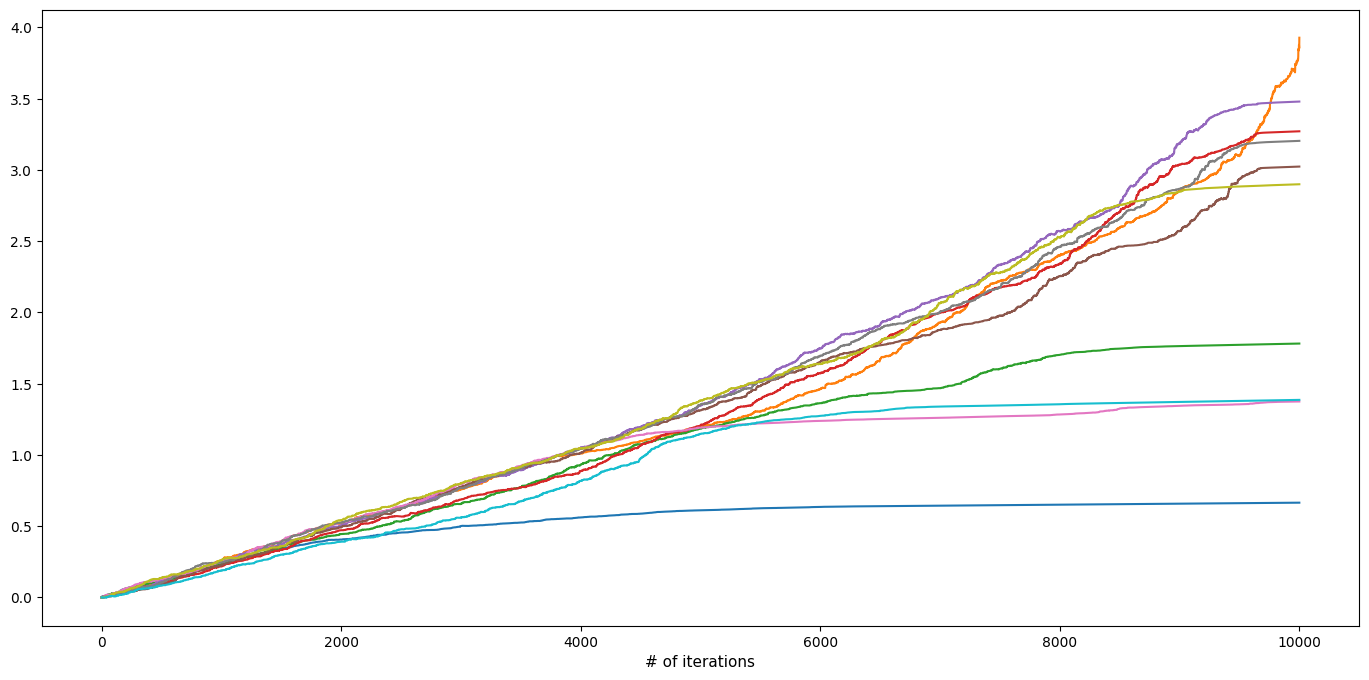

In [5]:
T = 1.0

V_i = black_scholes(S, K, sigma_i, T, r)
V_a = black_scholes(S, K, sigma_a, T, r)

#n_periods = 10000

fig, ax = plt.subplots(figsize=(17, 8))

for i in df_price_paths.columns[0:]:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r).Call_PnL
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r).Ptf_Total

    sns.lineplot(x=(df_call - df_ptf).index,
                 y=(df_call - df_ptf).values,
                 ax=ax)

plt.xlabel('# of iterations', fontsize=11)

plt.show()

##### The simulations shows that hedging with implied volatility lead to unknown $P\&L$

3. Think of additional analysis: consider how $ P\&L $ decomposes in terms of Greeks. <br> What is the impact of time-dependent Gamma $ \Gamma_{t} $? <br> What about $ r^2
− \sigma_{imp}\delta t $? <br> Consider findings
from Part II MVD modelling, what are the implications of hedging with the smaller delta?

The total profit can be expressed as:

$$ \frac{1}{2}\int_{t_{0}}^{T}e^{-r(t-t_{0})}\ S^2_{t}\ \Gamma^{i}_{t}\ (r^2_{t}-\sigma_{t,imp}^2t)dt $$

Which we will calculate for the same stock paths generated in the previous section

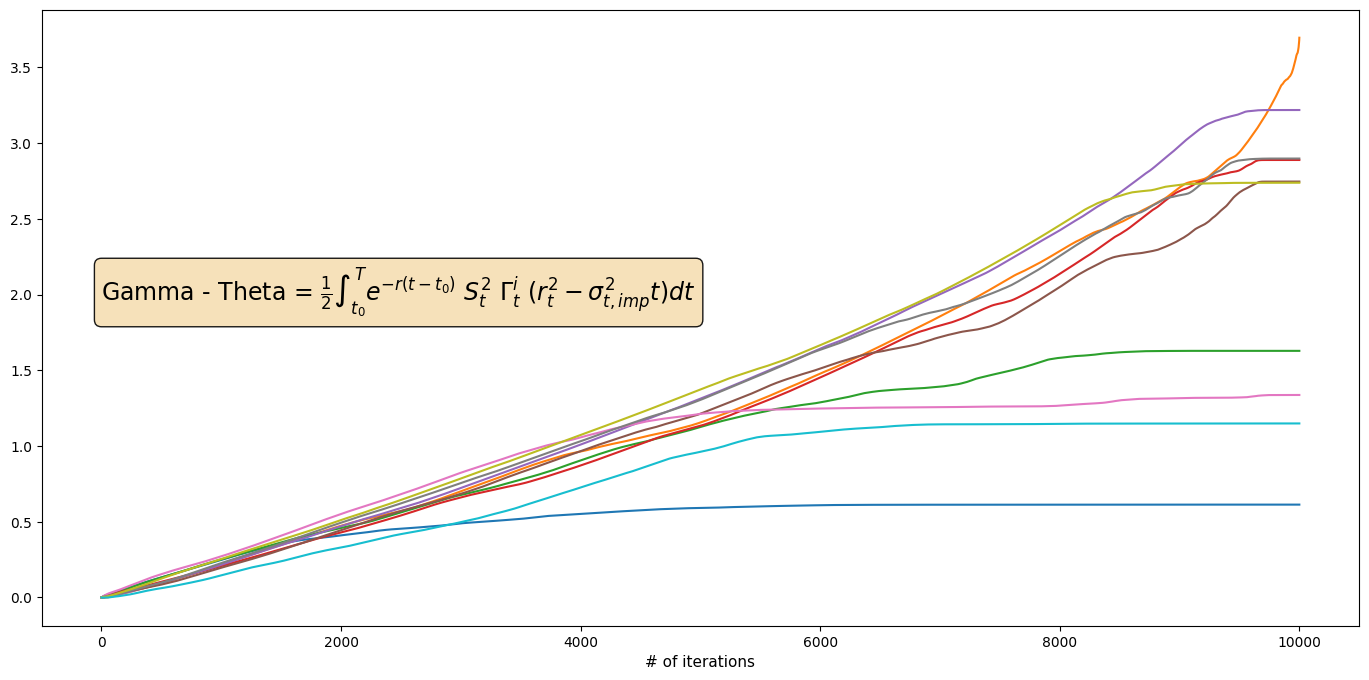

In [6]:
def hedge_with_implied(stock_path, gamma, sigma_a, sigma_i):
    
    n_periods = len(stock_path)

    realized_vol = np.sqrt((np.log(stock_path/stock_path.shift(1))**2).cumsum())/np.sqrt((np.array(range(0, n_periods))+1)/n_periods)
    realized_sigma = realized_vol**2
    discount_factors = np.exp(-r*((np.array(range(0, n_periods))+1)/n_periods))


    integral = (discount_factors*((stock_path)**2)*gamma*(realized_sigma-sigma_i**2)/n_periods).cumsum()

    return .5*integral


fig, ax = plt.subplots(figsize=(17, 8))

for i in df_price_paths.columns[0:]:

    stock_path = df_price_paths.loc[:, i]

    df_call = call_ptf(stock_path = stock_path, K=K, T=T,sigma=sigma_i, r=r)
    df_ptf = delta_hedged_ptf(stock_path = stock_path, K=K,T=T, sigma=sigma_i, r=r)

    sns.lineplot((hedge_with_implied(stock_path, df_call.Call_Gamma, sigma_a, sigma_i)),
                 ax=ax)
    
ax.text(x = 0, 
        y = V_a - V_i, 
        s = r'Gamma - Theta = $\frac{1}{2}\int_{t_{0}}^{T}e^{-r(t-t_{0})}\ S^2_{t}\ \Gamma^{i}_{t}\ (r^2_{t}-\sigma_{t,imp}^2t)dt$',
        bbox=props,
        fontsize=17)

plt.xlabel('# of iterations', fontsize=11)

plt.show()

As expected, the results match with the results obtained on the previous section

## Part II: Minimum Variance Delta

1. begin with sorting your IV data – or each trading day, you will need BS option price as
implied vol percentage, delta, and vega: ($ V_{t} $,$ \delta_{bs} $,$ \nu_{bs} $). <br> 
The term structure for option expiry $ 1M, 3M, 6M, 9M, 12M $, weekly expiries not necessary. <br> 
Key choice to make here, if
you are going to study Delta for out of the money call strikes, in addition to about ATM
buckets $ 0.45 < \delta_{bs} <0.55 $ – each strike means a separate a,b,c history for each expiry.

In this section, we read and parse calls and puts options data from OptionDX.com; <br>
Only options on the SPX from January 2010 from September 2023 are used; <br>

We are removing the following data:
 - Rows with <b> Null</b> values;
 - Options with expiration time below 14 days;
 - Rows with prices in holidays;

For each row, the price according to the Black Scholes formula is also calculated. <br>
All consolidated data is stored in the dataframe <b>df_option_data</b>


In [7]:
dict_dtpyes = {'[QUOTE_UNIXTIME]': int,
               ' [QUOTE_READTIME]' : object,
               ' [QUOTE_DATE]': str,
               ' [QUOTE_TIME_HOURS]': float, 
               ' [UNDERLYING_LAST]': float,
               ' [EXPIRE_DATE]': object,
               ' [EXPIRE_UNIX]': int,
               ' [DTE]': float,
               ' [C_DELTA]': object,
               ' [C_GAMMA]': object, 
               ' [C_VEGA]': object,
               ' [C_THETA]': object, 
               ' [C_RHO]': object, 
               ' [C_IV]': object, 
               ' [C_VOLUME]':object, 
               ' [C_LAST]': object,
               ' [C_SIZE]': object,
               ' [C_BID]': object, 
               ' [C_ASK]':object, 
               ' [STRIKE]': object, 
               ' [P_BID]':object,
               ' [P_ASK]':object,  
               ' [P_SIZE]':object, 
               ' [P_LAST]':object,
               ' [P_DELTA]': object,
               ' [P_GAMMA]': object,
               ' [P_VEGA]': object, 
               ' [P_THETA]': object, 
               ' [P_RHO]':object,
               ' [P_IV]':object,
               ' [P_VOLUME]': object,
               ' [STRIKE_DISTANCE]': float,
               ' [STRIKE_DISTANCE_PCT]': float}

csv_files = sorted(os.listdir('spx_eod_data'))

df_option_data = pd.DataFrame()

for file in csv_files:

    df_option_data = pd.concat([df_option_data,
                                pd.read_csv(filepath_or_buffer=f'spx_eod_data/{file}', 
                                            dtype=dict_dtpyes)
                                ])


#Parse Data
df_option_data.columns = [x.strip().replace('[','').replace(']','') for x in df_option_data.columns]
df_option_data['QUOTE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.QUOTE_DATE]
df_option_data['EXPIRE_DATE'] = [datetime.strptime(x.strip(),'%Y-%m-%d') for x in df_option_data.EXPIRE_DATE]

df_option_data = df_option_data.replace(' ', np.nan)
df_option_data = df_option_data[~df_option_data.isna().any(axis=1)]
df_option_data = df_option_data.loc[df_option_data.DTE > 14]

for col in ['C_DELTA', 'C_GAMMA', 'C_VEGA', 'C_THETA', 'C_RHO', 'C_IV', 'C_VOLUME', 'C_LAST', 'C_BID', 'C_ASK',
            'STRIKE', 'P_BID', 'P_ASK', 'P_LAST', 'P_DELTA', 'P_GAMMA', 'P_VEGA', 'P_THETA', 'P_RHO', 'P_IV', 'P_VOLUME', 
            'STRIKE_DISTANCE', 'STRIKE_DISTANCE_PCT']:
    
    df_option_data[col] = [float(x) for x in df_option_data[col]]

df_option_data['C_MID'] = (df_option_data['C_ASK']+df_option_data['C_BID'])/2
df_option_data['P_MID'] = (df_option_data['P_ASK']+df_option_data['P_BID'])/2

df_option_data = df_option_data.reset_index(drop=True)

#Obtain Black Scholes Prices
df_option_data['C_BS'] = [black_scholes(S=S,K=K,sigma=sigma,T=T/360,r=0) 
                          for S,K,sigma,T in zip(df_option_data['UNDERLYING_LAST'],
                                                 df_option_data['STRIKE'],
                                                 df_option_data['C_IV'], 
                                                 df_option_data['DTE'])]

df_option_data['P_BS'] = [black_scholes(S=S,K=K,sigma=sigma,T=T/360,r=0, option_type='put') 
                          for S,K,sigma,T in zip(df_option_data['UNDERLYING_LAST'],
                                                 df_option_data['STRIKE'],
                                                 df_option_data['C_IV'], 
                                                 df_option_data['DTE'])]

#Gather Holidays
pd.set_option('display.max_columns', None)

from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()

holidays = cal.holidays(start=df_option_data.QUOTE_DATE.min(), 
                        end=df_option_data.QUOTE_DATE.max())


/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_4249/1000109527.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))
/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_4249/1000109527.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = ((np.log(S/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T)))


2. compute your dependent variable and run the fitting on $ \delta_{bs} $,$ \delta^2_{bs} $. <br>Dependent side based
on daily option price changes $ \Delta V_{t} $, and you will need $( \Delta S_{t} , S_{t}) $ as well as Greeks noted
above. <br> The exact data columns will depend on how you organise regression or do SLSQP.

In this section, we extract only data for calls and remove the follwing rows: - deep ITM (absolute delta above 95%) 
- deep OTM (absolute delta below 5%)
- outlier <b>C_LAST/ P_LAST</b> prices compared to Black Scholes prices
- calls/puts with no volume dring the day

Each price is label on a Delta bucket (from .1 to .9) and a maturity bucket ('1M', '3M', '6M', '9M', '12M') <br>
The resulting data is stored in <b>df_calls</b>/<b>df_puts</b>

The next step is to compare the evolution of each contract from one day to the next day. <br>
To do this, each option is specified by <b>EXPIRE_UNIX</b> and <b>STRIKE</b> and its data is compared with the data on the previous trading day. <br>
On each comparison the following columns are removed: <br>

 - Different delta buckets between days;
 - Different expiry buckets between days;
 - Days with very tiny underlying price movements;


On each comparison the following columns are calculated:

 - <b>delta_price</b>: variation of last price
 - <b>delta_IV</b>: variation of Implied volatility 
 - <b>delta_S</b>: variation of Underlying asset
 - <b>y</b>: variable used for future fitting


In [8]:
df_calls = df_option_data.set_index(['QUOTE_DATE','EXPIRE_UNIX','STRIKE'])[['UNDERLYING_LAST', 'DTE', 'C_DELTA', 'C_VEGA', 'C_IV', 'C_LAST','C_MID','C_BS','C_VOLUME']]
df_calls['QUOTE_DATE'] = df_calls.index.get_level_values(0)

df_calls = df_calls[(df_calls.C_DELTA < .95)&(df_calls.C_DELTA > .05)]
df_calls = df_calls[~df_calls.index.get_level_values(0).isin(holidays)].copy()
df_calls = df_calls[df_calls.C_VOLUME!=0].copy()

df_calls['BS_Delta_Bucket'] = [round(x*10)/10 for x in df_calls.C_DELTA]

df_calls['Expiry_Bucket'] = pd.cut(df_calls.DTE,[14, 30, 91, 182, 365, 
                                                 df_calls.DTE.max()],
                                        labels=['1M', '3M', '6M', '9M', '12M'])

# Eliminate outliers prices compared to Black Scholes price

q75, q25 = np.percentile((df_calls['C_LAST']-df_calls['C_BS']).values,
                          [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls = df_calls[(df_calls['C_LAST']-df_calls['C_BS'] > cut_min) 
                    & (df_calls['C_LAST']-df_calls['C_BS'] < cut_max)].copy()

quote_dates = sorted(df_calls.index.get_level_values(0).unique())

df_calls_diff = df_calls.loc[quote_dates[0]].merge(
    df_calls.loc[quote_dates[1]], 
    left_index=True, 
    right_index=True, 
    suffixes=('_t1','_t0'), 
    how='inner')


for i in range(len(quote_dates[2:])):
    df_calls_diff = pd.concat([df_calls_diff,
                               df_calls.loc[quote_dates[i+1]].merge(
                                   df_calls.loc[quote_dates[i+2]], 
                                   left_index=True,
                                   right_index=True,
                                   suffixes=('_t1','_t0'),
                                   how='inner')],
                     axis=0)

#df_calls_diff = df_calls_diff[df_calls_diff.BS_Delta_Bucket_t1 == df_calls_diff.BS_Delta_Bucket_t0].copy()
df_calls_diff = df_calls_diff[df_calls_diff.Expiry_Bucket_t1 == df_calls_diff.Expiry_Bucket_t0].copy()

df_calls_diff = df_calls_diff[df_calls_diff['C_LAST_t1']-df_calls_diff['C_LAST_t0'] != 0]
    
df_calls_diff['delta_price'] = df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1']
df_calls_diff['delta_S'] = df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_price_perc'] = (df_calls_diff['C_LAST_t0'] - df_calls_diff['C_LAST_t1'])/df_calls_diff['C_LAST_t1']
df_calls_diff['delta_S_perc'] = (df_calls_diff['UNDERLYING_LAST_t0'] - df_calls_diff['UNDERLYING_LAST_t1'])/df_calls_diff['UNDERLYING_LAST_t1']

df_calls_diff['delta_IV'] = df_calls_diff['C_IV_t0']-df_calls_diff['C_IV_t1']

df_calls_diff = df_calls_diff.rename({'BS_Delta_Bucket_t1':'BS_Delta_Bucket',
                                      'Expiry_Bucket_t1':'Expiry_Bucket'
                                      },axis=1)

df_calls_diff = df_calls_diff.drop(['BS_Delta_Bucket_t0','Expiry_Bucket_t0'])

df_calls_diff = df_calls_diff[abs(df_calls_diff.delta_S_perc) > 1e-4].copy()
df_calls_diff = df_calls_diff.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket','Expiry_Bucket'])

df_calls_diff['delta_IV'] = df_calls_diff['C_IV_t0'] - df_calls_diff['C_IV_t1']

df_calls_diff['y'] = (df_calls_diff['delta_price']/df_calls_diff['delta_S'] - df_calls_diff['C_DELTA_t1'])*df_calls_diff['UNDERLYING_LAST_t1']*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)
df_calls_diff['y_perc'] = (df_calls_diff['delta_price_perc']/df_calls_diff['delta_S_perc']-df_calls_diff['C_DELTA_t1'])*np.sqrt(df_calls_diff['DTE_t1']/360)/(df_calls_diff['C_VEGA_t1']*100)

df_calls_diff['delta_S_perc/sqrt_t'] = df_calls_diff['delta_S_perc']/np.sqrt(df_calls_diff['DTE_t0']/360)

# Eliminate outliers on y
q75, q25 = np.percentile(df_calls_diff.y, [75,25])
intr_qr = q75-q25

cut_max = q75+(1.5*intr_qr)
cut_min = q25-(1.5*intr_qr)

df_calls_diff = df_calls_diff[(df_calls_diff['y'] > cut_min) & (df_calls_diff['y'] < cut_max)].copy()

In [9]:
#df_puts_diff['y'] = (df_puts_diff['delta_price']/df_puts_diff['delta_S'] - df_puts_diff['P_DELTA_t1'])*df_puts_diff['UNDERLYING_LAST_t1']*np.sqrt(df_puts_diff['DTE_t1']/360)/(df_puts_diff['P_VEGA_t1']*100)


3. parameters a,b,c can be constant for a study project, but rolling estimation itself is a calibration
technique because for each expiry, you have time-dependent a,b,c (not 3 constants). <br>Hull White
recipe was 3M rolling window, then shift the start date by one day (3 ×22 obs) – you can estimate
with shorter/longer periods or shift by 5−10 days.<br> Also remember, option IVs can be simulated
from a uniform distribution recipe.

4. For model validation, look at change of a,b,c over time – we use regression as a fitting tool
so they might not even be statistically significant. <br>Check if δMV−δBS gives an (inverted)
parabolic shape, plot expected change in IV vs Delta.

In this section, we are fitting the rolling parameters for each testing window and each expiry bucket. <br>The parameters are fitted for 36 months windows (756 trading days). <br>The plot below shows the evolution of those parameters for each expiry bucket and also an aggregated set of parameters.




In [10]:
def get_r_squared(df_option_prices):

    df = df_option_prices[['delta_IV', 'delta_S_perc', 'DTE_t1']].copy()
    df['x'] = df['delta_S_perc']/np.sqrt(df['DTE_t1']/360)
    result = pd.Series(index=sorted(df.index.get_level_values(1).unique()))

    for bs_bucket in sorted(df.index.get_level_values(1).unique()):
        try:
            slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y=df.xs(bs_bucket, level='BS_Delta_Bucket').delta_IV,
                                                                            x=df.xs(bs_bucket, level='BS_Delta_Bucket').x)
            
            result.loc[bs_bucket] = r_value**2
        except:
            pass
                
    return result
    
    
def quadratic_fit(df_option_prices,option_type='call'):

    df = df_option_prices.groupby(['Expiry_Bucket','BS_Delta_Bucket'],
                                  observed=True).y.mean()

    expiry_buckets  = df.index.get_level_values(0).unique().to_list() + ['Total']

    df_result = pd.DataFrame(index=expiry_buckets,
                             columns=['a', 'b', 'c'])

    if option_type == 'call':

        for expiry in expiry_buckets[:-1]:

            c,b,a = np.polyfit(y=df.loc[expiry],
                            x=df.loc[expiry].index,
            deg=2)
            
            df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]
        
        c,b,a = np.polyfit(y=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                    observed=True).y.mean(),
                            x=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                    observed=True).y.mean().index,
            deg=2)
        
    elif option_type == 'put':

        for expiry in expiry_buckets[:-1]:

            c,b,a = np.polyfit(y=df.loc[expiry],
                            x=df.loc[expiry].index+1,
            deg=2)
            
            df_result.loc[expiry,['a', 'b', 'c']] = [a, b, c]
        
        c,b,a = np.polyfit(y=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                    observed=True).y.mean(),
                            x=df_option_prices.groupby(['BS_Delta_Bucket'],
                                                    observed=True).y.mean().index+1,
            deg=2)

    else:
    
        raise Exception('Option type not supported')


    
    df_result.loc['Total',['a', 'b', 'c']] = [a, b, c]

    return df_result

In [11]:
#Set training and testing parameters

TRAINING_PERIOD = 21*36 #36 months
TESTING_PERIOD = 40 #2 months

df_call_quote_dates = pd.Series(df_calls_diff.index.get_level_values(0).unique())

import itertools

lists = [
   df_call_quote_dates.loc[TRAINING_PERIOD:].values,
   df_calls_diff.index.get_level_values(2).unique().categories.to_list() + ['Total']
   
]

df_call_params = pd.DataFrame(columns=['a','b','c'],
                         index=pd.MultiIndex.from_tuples(itertools.product(*lists)))

df_call_params.index.names = ['end_testing', 'expiry_bucket']

df_call_params['start_testing'] = df_call_params.index.get_level_values(0).map(
    {end:start for 
     end,start in 
     zip(df_call_quote_dates.loc[TRAINING_PERIOD:].values, 
         df_call_quote_dates.loc[:].values)})


#Fitting a,b, and c on each training window
for i in range(0, len(df_call_quote_dates)-TRAINING_PERIOD):

    training_period = df_call_quote_dates.loc[i:i+TRAINING_PERIOD].values

    df_call_params.loc[training_period[-1], ['a', 'b', 'c']] = quadratic_fit(df_calls_diff.loc[training_period]).values

df_call_params['minus_b'] = -df_call_params['b']

/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_4249/1090426962.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


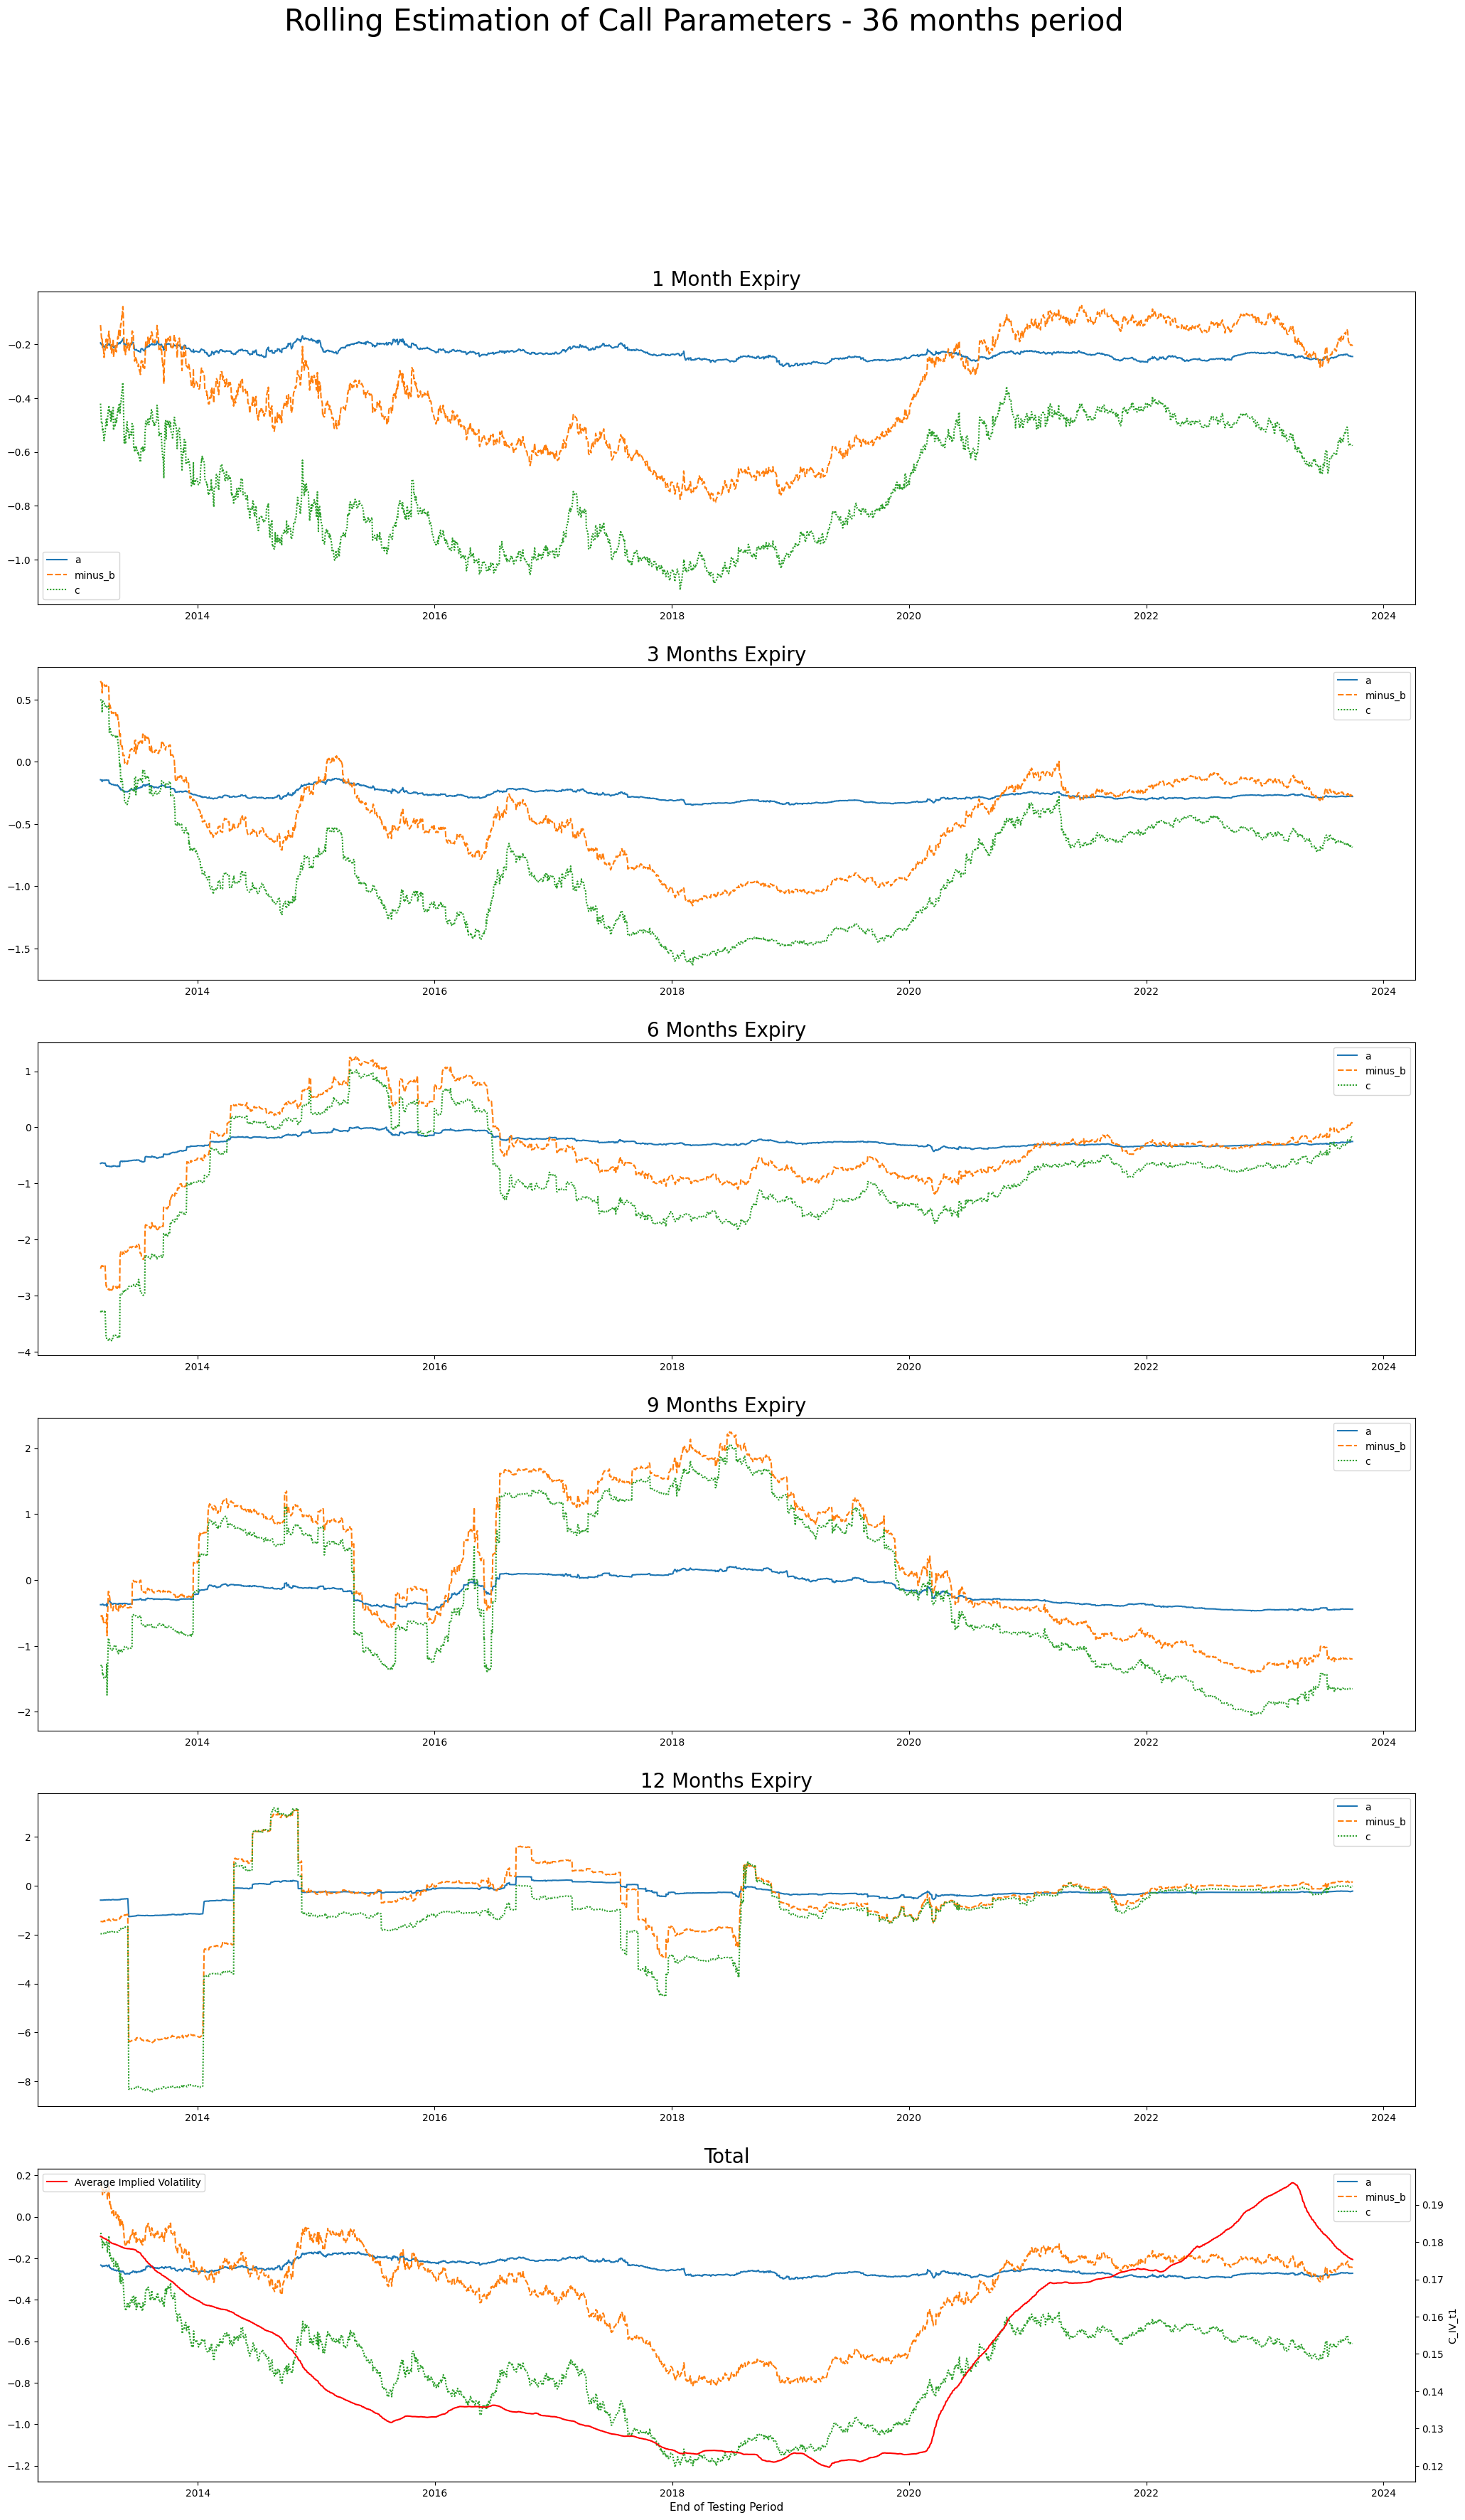

In [12]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(25, 40))

fig.suptitle('Rolling Estimation of Call Parameters - 36 months period', 
             fontsize=30)

sns.lineplot(df_call_params.xs('1M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[0])
ax[0].set_title('1 Month Expiry', fontsize=20)
ax[0].set_xlabel(None)

sns.lineplot(df_call_params.xs('3M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[1])
ax[1].set_title('3 Months Expiry',fontsize=20)
ax[1].set_xlabel(None)

sns.lineplot(df_call_params.xs('6M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[2])
ax[2].set_title('6 Months Expiry', fontsize=20)
ax[2].set_xlabel(None)

sns.lineplot(df_call_params.xs('9M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[3])
ax[3].set_title('9 Months Expiry', fontsize=20)
ax[3].set_xlabel(None)

sns.lineplot(df_call_params.xs('12M',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[4])
ax[4].set_title('12 Months Expiry', fontsize=20)
ax[4].set_xlabel(None)

sns.lineplot(df_call_params.xs('Total',level='expiry_bucket')[['a','minus_b','c']]
             ,ax=ax[5]
             ,legend=True)

ax[5].set_title('Total', fontsize=20)
ax[5].set_xlabel('End of Testing Period', fontsize=11)

ax_twin = ax[5].twinx()

#ax_twin.set_yticks(np.linspace(ax_twin.get_yticks()[0], ax_twin.get_yticks()[-1], len(ax[5].get_yticks())))
#ax.grid()

sns.lineplot(df_calls_diff.groupby('QUOTE_DATE_t1').C_IV_t1.mean().rolling(TRAINING_PERIOD).mean(),
             ax=ax_twin,
             color="r")



ax_twin.legend(['Average Implied Volatility'], 
                loc="upper left")

fig.show()


We can see the parameters for maturities above 3M are very unstable due to its poor liquidity. <br> For expiries with more liquidity, the quadratic parameter (c) is negative on almost all cases, giving us an inverted parabola. <br>
<br>
On the overall trend, we can see a close relation between the average level of implied volatility in the period and the fitted factors.<br>In periods with lower (higher) volatility, the linear and quadratic factors tends to increase(decrease) in absolute values. <br>Thus, in higher volatility periods, the difference between MV hedging and BS hedging narrows. <br>This can also suggests a weaker relation, in periods of higher uncertainty, between expected changes in volatility and future returns.


/var/folders/_r/h1v0kxm14l9gftzvckvrlllr0000gn/T/ipykernel_4249/1084328597.py:32: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(x='BS_Delta_Bucket',


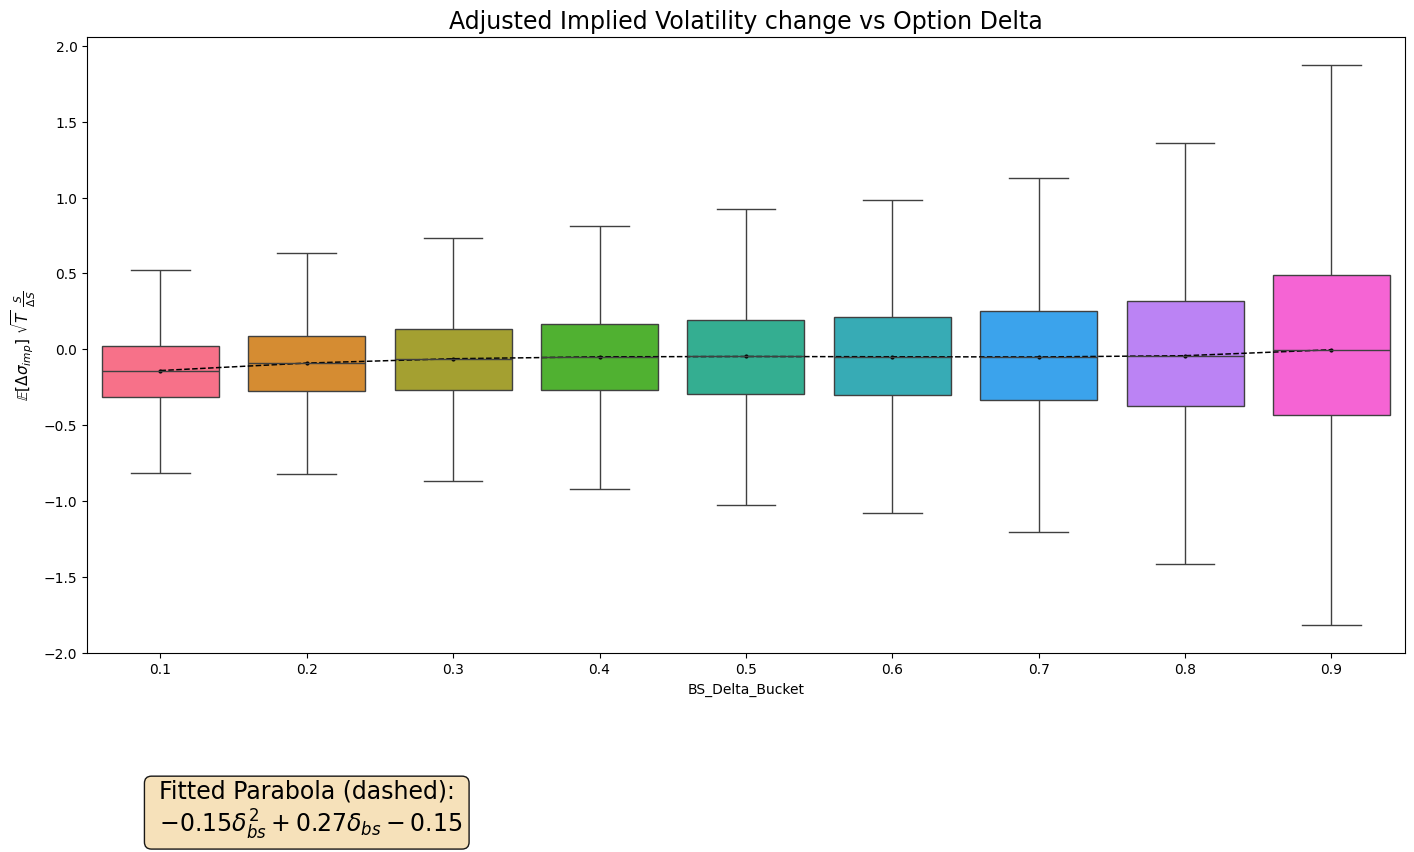

In [13]:
df_plot_IV = df_calls_diff.copy()

df_plot_IV = df_plot_IV.delta_IV*np.sqrt(df_plot_IV.DTE_t1/360)/df_plot_IV['delta_S_perc']
df_plot_IV = df_plot_IV[(df_plot_IV > cut_min) & (df_plot_IV < cut_max)].copy()

df_plot_IV.name = 'adjusted_exp_IV'
df_plot_IV = df_plot_IV.to_frame().reset_index()

df_plot_IV['BS_Delta_Bucket'] = df_plot_IV['BS_Delta_Bucket'].astype('category')
df_plot_IV_line = df_plot_IV.groupby('BS_Delta_Bucket',observed=False).adjusted_exp_IV.median().to_frame().reset_index()

c,b,a = np.polyfit(y=df_plot_IV_line.adjusted_exp_IV,
                    x=df_plot_IV_line.BS_Delta_Bucket,
    deg=2)


fig, ax = plt.subplots(figsize=(17, 8))

ax.set_title('Adjusted Implied Volatility change vs Option Delta',
             fontsize=17)

sns.boxplot(x='BS_Delta_Bucket',
            y='adjusted_exp_IV',
            #hue='Expiry_Bucket',
            data=df_plot_IV,
            showfliers = False,
            palette="husl",
            hue='BS_Delta_Bucket',
            legend=False,
            saturation=1)

sns.pointplot(x='BS_Delta_Bucket',
              y='adjusted_exp_IV',
              data=df_plot_IV_line,
              linestyles='--', 
              scale=0.4, 
              color='k', 
              err_kws={'linewidth': 0}, 
              capsize=0)

ax.text(x = 1, 
        y = df_plot_IV.adjusted_exp_IV.min(), 
        s = r'Fitted Parabola (dashed):'+'\n'+ r' $'+str(np.round(c,2))+r'\delta^2_{bs}+' + str(np.round(b,2))+r'\delta_{bs} ' + str(np.round(a,2))+r'$', 
        horizontalalignment='center', 
        #verticalalignment='top', 
        bbox=props,
        fontsize=17)

plt.ylabel(r'$\mathbb{E}[\Delta \sigma_{imp}]\ \sqrt{T}\ \frac{S}{\Delta S}$', fontsize=11)

plt.show()

The chart above shows the relation of adjusted changes in volatility and BS delta for every trading day on the dataset. <br> We can see a parabolic trend, but most of the varition cannot be explained by this simples relation.

5. $\mathbb{E}[\Delta \sigma_{imp}]$ expected to be negative but might not be. <br> 
Is your achieved hedging Gain anywhere close to 15% and in which delta buckets and expiries?

In [14]:
TESTING_PERIOD = 40 #2 months

#declare df_gain_n_observations
lists = [
   df_call_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique())
   ]

df_gain_n_observations = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                                      columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_n_observations.index.names = ['start_testing', 'delta_bucket']

#declare df_r_squared
lists = [
   df_call_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']
   ]

df_r_squared = pd.DataFrame(index=df_call_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
                            columns=sorted(df_calls_diff.index.get_level_values(1).unique()))

lists = [
   df_call_quote_dates.loc[TRAINING_PERIOD+1:].iloc[:-TESTING_PERIOD],
   sorted(df_calls_diff.index.get_level_values(1).unique()) + ['Total']
   ]

#df_gain_mv
df_gain_mv = pd.DataFrame(index=pd.MultiIndex.from_tuples(itertools.product(*lists)),
                          columns=df_calls_diff.index.get_level_values(2).unique().categories)

df_gain_mv.index.names = ['start_testing','delta_bucket']
df_gain_mv['Total'] = np.nan

for i in range(0, len(df_call_quote_dates)-TRAINING_PERIOD-TESTING_PERIOD-1):
    
        testing_period = df_call_quote_dates.loc[i+TRAINING_PERIOD: i+TRAINING_PERIOD+TESTING_PERIOD].values

        df_loop = pd.merge(df_calls_diff.loc[testing_period[1:]].reset_index(),
                           df_call_params.loc[testing_period[0],['a','b','c']].reset_index(),
                           left_on = 'Expiry_Bucket',
                           right_on = 'expiry_bucket'
                           )

        df_loop['epsilon_bs'] = df_loop['delta_price'] - df_loop['BS_Delta_Bucket']*df_loop['delta_S']

        df_loop['Delta_MV'] = df_loop['BS_Delta_Bucket'] + (df_loop['C_VEGA_t1']*100
                                                            *(df_loop['a']+df_loop['b']*df_loop['BS_Delta_Bucket']+df_loop['c']*(df_loop['BS_Delta_Bucket']**2))
                                                            /(np.sqrt(df_loop['DTE_t1']/360)*df_loop['UNDERLYING_LAST_t1']))

        df_loop['epsilon_mv'] = df_loop['delta_price'] - df_loop['Delta_MV']*df_loop['delta_S']

        df_epsilon_bs = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_bs)**2))
                                        .unstack())

        df_epsilon_bs['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_bs)**2)))


        df_epsilon_bs.loc['Total'] = (df_loop
                                      .groupby('Expiry_Bucket',
                                               observed=True)
                                               .apply(lambda x: sum((x.epsilon_bs)**2)))

        df_epsilon_bs.loc['Total', 'Total'] = sum(df_loop['epsilon_bs']**2)

        df_epsilon_mv = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'],
                                        observed=True)
                                        .apply(lambda x: sum((x.epsilon_mv)**2))
                                        .unstack())

        df_epsilon_mv['Total'] = (df_loop
                                        .groupby('BS_Delta_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))


        df_epsilon_mv.loc['Total'] = (df_loop
                                        .groupby('Expiry_Bucket',
                                                observed=True)
                                                .apply(lambda x: sum((x.epsilon_mv)**2)))

        df_epsilon_mv.loc['Total', 'Total'] = sum(df_loop['epsilon_mv']**2)

        if len(df_epsilon_mv.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

                for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_mv.columns):

                        df_epsilon_mv[col] = np.nan

        if len(df_epsilon_bs.columns) < len(df_gain_mv.loc[testing_period[1]].columns):

                for col in set(df_gain_mv.loc[testing_period[1]].columns)-set(df_epsilon_bs.columns):

                        df_epsilon_bs[col] = np.nan

        df_epsilon_bs = df_epsilon_bs[df_gain_mv.loc[testing_period[1]].columns]
        df_epsilon_mv = df_epsilon_mv[df_gain_mv.loc[testing_period[1]].columns]

        df_gain_mv.loc[testing_period[1]].loc[df_epsilon_mv.index] = (1 - df_epsilon_mv/df_epsilon_bs)
        
        df_loop_observations = (df_loop.groupby(['BS_Delta_Bucket','Expiry_Bucket'], observed=True)
                                .QUOTE_DATE_t1.count()
                                .unstack())
        
        if len(df_loop_observations.columns) < len(df_gain_n_observations.loc[testing_period[1]].columns):

                for col in set(df_gain_n_observations.loc[testing_period[1]].columns)-set(df_loop_observations.columns):

                        df_loop_observations[col] = np.nan

        df_loop_observations = df_loop_observations[df_gain_n_observations.loc[testing_period[1]].columns]
        
        df_gain_n_observations.loc[testing_period[1]].loc[sorted(df_loop.BS_Delta_Bucket.unique())] = df_loop_observations
        df_r_squared.loc[testing_period[1]] = get_r_squared(df_loop.set_index(['QUOTE_DATE_t1','BS_Delta_Bucket', 'Expiry_Bucket']))


df_gain_mv = df_gain_mv.astype(float)
df_r_squared = df_r_squared.astype(float)
df_gain_n_observations = df_gain_n_observations.astype(float)

df_gain_n_observations['Total'] = df_gain_n_observations.sum(1)

In [15]:
def float_to_raw_string(number, format):
    
    if format == 'percentage':
        return f'{number:.1f}' + r'\%'
    if format == 'float_2digits':
        return f'{number:.2f}'
    if format == 'float_1digit':
        return f'{number:.1f}'
    if format == 'int':
        return f'{int(number):,}'


def dataframe_to_latex(df,title,format,total):

    n_rows, n_cols = df.shape

    str_latex = r"""$$ 
    \begin{aligned}
    & \text {""" + title + r"""}\\
    &\begin{array}{|c|r|r|r|r|r|r|}
    \hline \hline 
    \text { """+df.index.name.replace('_',' ') +r"""} """+''.join(["& \t {"+x+"} " for x in df.columns])+r"""
    
    \\
    \hline """

    for i in df.index:

        if total:
            if i !=df.index[-1]:
                str_latex=str_latex+str(i)+r"""& """ 
            else:
                
                str_latex=str_latex+r"""\hline """+str(df.loc[i].name)+r""" &"""

        else:
            str_latex=str_latex+str(i)+r"""& """ 

        for j in df.columns:
            if j  != df.columns[-1]: 
                str_latex=str_latex + \
                    float_to_raw_string(df.loc[i,j],format) + r'&'
            else:
                str_latex=str_latex + float_to_raw_string(df.loc[i,j],format)
        str_latex=str_latex+r"""\\ """


    str_latex=str_latex+r"""\hline

    \end{array}
    \end{aligned}
    $$"""

    display(Latex(str_latex))

# bool_array = np.diff([x.year*10+x.month for x in df_gain_mv.index.get_level_values(0).unique()])
# bool_array = [bool(x) for x in bool_array]

# first_days = pd.Series(df_gain_mv.index.get_level_values(0).unique())[1:][bool_array].values
# df_gain_mv_summary = df_gain_mv.loc[first_days].groupby('delta_bucket').mean()*100
df_gain_mv_summary = df_gain_mv.groupby('delta_bucket').mean()*100

df_n_observations = df_gain_n_observations.fillna(0).groupby('delta_bucket').mean()
df_n_observations.loc['Total'] = df_n_observations.sum()

dataframe_to_latex(df=df_gain_mv_summary,
                   title='Average gains for each delta and expiry buckets',
                   format='percentage',
                   total=True)

dataframe_to_latex(df_n_observations,
                   title='Average daily comparisons for each bucket',
                   format='int',
                   total=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Differently from the Hull & White paper, we get better gains for ITM calls and specially poor values for deep OTM calls (.1 delta) <br>
The overall gain is satisfactory (above 15%) <br>

The liquidity on options with expiry buckets greater than 6M is lower, specially for deep OTM and deep ITM options, this can cause negative gains on these buckets, but their errors do not have a great impact on the total gain. <br>

More robust results can be found in ATM options (delta between .4 and .6) on the 1M and 3M buckets